In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [26]:
import numpy as np
import pandas as pd
df = pd.read_csv('lung cancer survey.csv')
df_no_na = df.dropna()

df_age = df_no_na[df_no_na["AGE"] > 21]
# Use df_age for all models, where clustering algorithm models, such as Kmeans, randomforest, decision tree as they would have already categorise an age threshold within the model
df_age

# Use df_cluster only for logistic regression, lasso, ridge and elastic net - cross comparison of these models with df_age
df_cluster = df_age.copy()
df_cluster['cluster'] = df_cluster['AGE'].apply(lambda x: 1 if x >= 61 else 0)
df_cluster = df_cluster.drop("AGE", axis = 1)
df_cluster

,GENDER,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER,cluster
0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
1,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1
2,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8996,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
8997,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1
8998,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1
8999,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1


In [4]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import export_text

feature_names = df_age.columns.drop(["LUNG_CANCER"])
X = df_age[feature_names].values
y = df_age["LUNG_CANCER"].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 888)

decision_tree = DecisionTreeClassifier(criterion = "entropy", random_state = 888)
path = decision_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

trees = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion = "entropy", random_state = 888, ccp_alpha = ccp_alpha)
    trees.append(clf)

kf = KFold(n_splits = 10, shuffle = True, random_state = 888)
mean_cv_errors = []

for clf in trees:
    # Perform cross-validation and get the average error for each alpha
    cv_scores = cross_val_score(clf, X_train, y_train, cv=kf, scoring='precision')
    mean_cv_errors.append(np.mean(cv_scores))  # Get average accuracy for each alpha

optimal_alpha_index = np.argmax(mean_cv_errors)
optimal_alpha = ccp_alphas[optimal_alpha_index]
print(f"Optimal alpha: {optimal_alpha}")

pruned_tree = DecisionTreeClassifier(criterion = "entropy", random_state = 888, ccp_alpha = optimal_alpha)
pruned_tree.fit(X_train, y_train)

# Step 7: Evaluate the pruned tree on the validation set
y_pred_pruned = pruned_tree.predict(X_val)
print(f"Accuracy with pruning: {accuracy_score(y_val, y_pred_pruned):.2f}")
print(f"Precision with pruning: {precision_score(y_val, y_pred_pruned):.2f}")
print(f"Recall with pruning: {recall_score(y_val, y_pred_pruned):.2f}")
print(f"F1-Score with pruning: {f1_score(y_val, y_pred_pruned):.2f}")

Optimal alpha: 0.0003145364592347786
Accuracy with pruning: 0.84
Precision with pruning: 0.88
Recall with pruning: 0.92
F1-Score with pruning: 0.90


Optimal Number of Trees: 196
Corresponding Accuracy Score: 0.8733333333333333
Corresponding Precision Score: 0.9797486033519553
Corresponding Recall Score: 0.8757802746566792
Corresponding F1 Score: 0.924851680949242


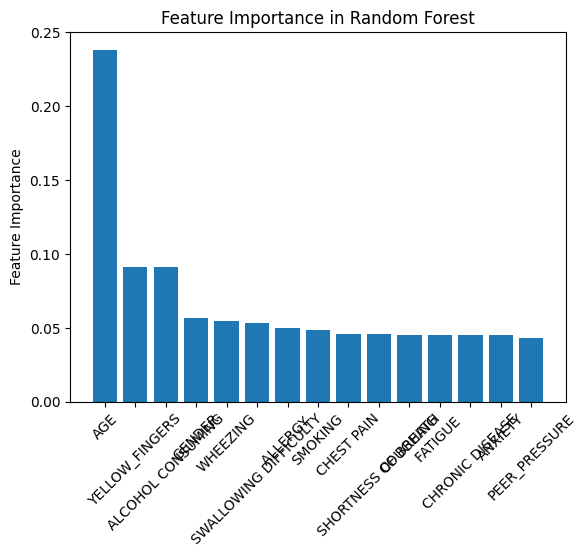

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

forests  = []
number_of_trees = range(50, 201)
for i in number_of_trees:
    random_forest = RandomForestClassifier(n_estimators = i, random_state = 888, max_features = "sqrt", criterion = "entropy")
    forests.append(random_forest)

kf = KFold(n_splits = 10, shuffle = True, random_state = 888)
mean_cv_errors = []

for rf in forests:
    cv_scores = cross_val_score(rf, X_train, y_train, cv = kf, scoring = 'precision')
    mean_cv_errors.append(np.mean(cv_scores))  

optimal_number_of_trees_index = np.argmax(mean_cv_errors)
optimal_number_of_trees = number_of_trees[optimal_number_of_trees_index]
print(f"Optimal Number of Trees: {optimal_number_of_trees}")

new_forest = RandomForestClassifier(n_estimators = optimal_number_of_trees, random_state = 888, max_features = "sqrt", criterion = "entropy")
new_forest.fit(X_train, y_train)
y_pred = new_forest.predict(X_val)

print(f"Corresponding Accuracy Score: {accuracy_score(y_pred, y_val)}")
print(f"Corresponding Precision Score: {precision_score(y_pred, y_val)}")
print(f"Corresponding Recall Score: {recall_score(y_pred, y_val)}")
print(f"Corresponding F1 Score: {f1_score(y_pred, y_val)}")

feature_importances = new_forest.feature_importances_

# Do a reverse sorted vertical bar plot
indices = np.argsort(feature_importances)[::-1]           # [::-1] reverses the order
plt.bar(np.array(feature_names)[indices], feature_importances[indices])
plt.ylabel('Feature Importance')
plt.title('Feature Importance in Random Forest')
plt.xticks(rotation=45)                                   # otherwist xticks is overcrowded with text
plt.show()


Optimal Number of Trees For Maximizing F1: 86
Corresponding Accuracy Score: 0.8738888888888889
Corresponding Precision Score: 0.9783519553072626
Corresponding Recall Score: 0.8772698810269255
Corresponding F1 Score: 0.9250577748431825


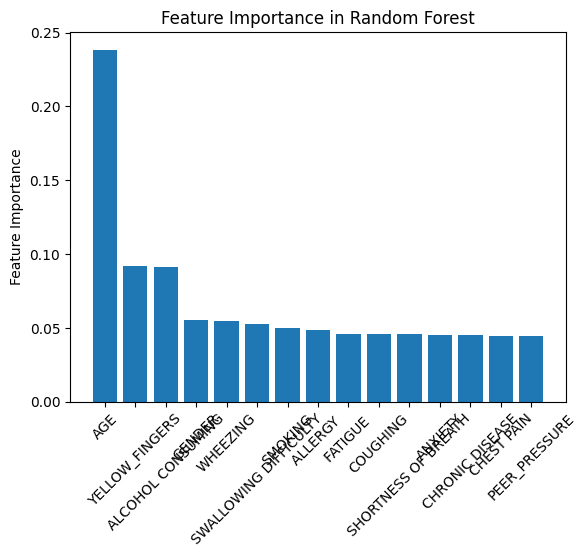

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

forests  = []
number_of_trees = range(50, 201)
for i in number_of_trees:
    random_forest = RandomForestClassifier(n_estimators = i, random_state = 888, max_features = "sqrt", criterion = "entropy")
    forests.append(random_forest)

kf = KFold(n_splits = 10, shuffle = True, random_state = 888)
mean_cv_errors = []

for rf in forests:
    cv_scores = cross_val_score(rf, X_train, y_train, cv = kf, scoring = 'f1')
    mean_cv_errors.append(np.mean(cv_scores))  

optimal_number_of_trees_index = np.argmax(mean_cv_errors)
optimal_number_of_trees = number_of_trees[optimal_number_of_trees_index]
print(f"Optimal Number of Trees For Maximizing F1: {optimal_number_of_trees}")

new_forest = RandomForestClassifier(n_estimators = optimal_number_of_trees, random_state = 888, max_features = "sqrt", criterion = "entropy")
new_forest.fit(X_train, y_train)
y_pred = new_forest.predict(X_val)

print(f"Corresponding Accuracy Score: {accuracy_score(y_pred, y_val)}")
print(f"Corresponding Precision Score: {precision_score(y_pred, y_val)}")
print(f"Corresponding Recall Score: {recall_score(y_pred, y_val)}")
print(f"Corresponding F1 Score: {f1_score(y_pred, y_val)}")

feature_importances = new_forest.feature_importances_

# Do a reverse sorted vertical bar plot
indices = np.argsort(feature_importances)[::-1]           # [::-1] reverses the order
plt.bar(np.array(feature_names)[indices], feature_importances[indices])
plt.ylabel('Feature Importance')
plt.title('Feature Importance in Random Forest')
plt.xticks(rotation=45)                                   # otherwist xticks is overcrowded with text
plt.show()

Optimal Number of Trees: 196
Corresponding Accuracy Score: 0.8733333333333333
Corresponding Precision Score: 0.9797486033519553
Corresponding Recall Score: 0.8757802746566792
Corresponding F1 Score: 0.924851680949242


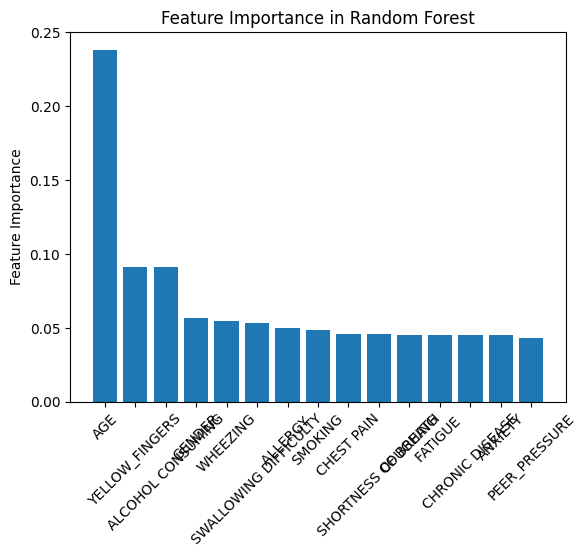

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

forests  = []
number_of_trees = range(50, 201)
for i in number_of_trees:
    random_forest = RandomForestClassifier(n_estimators = i, random_state = 888, max_features = "sqrt", criterion = "log_loss")
    forests.append(random_forest)

kf = KFold(n_splits = 10, shuffle = True, random_state = 888)
mean_cv_errors = []

for rf in forests:
    cv_scores = cross_val_score(rf, X_train, y_train, cv = kf, scoring = 'precision')
    mean_cv_errors.append(np.mean(cv_scores))  

optimal_number_of_trees_index = np.argmax(mean_cv_errors)
optimal_number_of_trees = number_of_trees[optimal_number_of_trees_index]
print(f"Optimal Number of Trees: {optimal_number_of_trees}")

new_forest = RandomForestClassifier(n_estimators = optimal_number_of_trees, random_state = 888, max_features = "sqrt", criterion = "log_loss")
new_forest.fit(X_train, y_train)
y_pred = new_forest.predict(X_val)

print(f"Corresponding Accuracy Score: {accuracy_score(y_pred, y_val)}")
print(f"Corresponding Precision Score: {precision_score(y_pred, y_val)}")
print(f"Corresponding Recall Score: {recall_score(y_pred, y_val)}")
print(f"Corresponding F1 Score: {f1_score(y_pred, y_val)}")

feature_importances = new_forest.feature_importances_

# Do a reverse sorted vertical bar plot
indices = np.argsort(feature_importances)[::-1]           # [::-1] reverses the order
plt.bar(np.array(feature_names)[indices], feature_importances[indices])
plt.ylabel('Feature Importance')
plt.title('Feature Importance in Random Forest')
plt.xticks(rotation=45)                                   # otherwist xticks is overcrowded with text
plt.show()

Optimal Number of Trees For Maximizing F1: 86
Corresponding Accuracy Score: 0.8738888888888889
Corresponding Precision Score: 0.9783519553072626
Corresponding Recall Score: 0.8772698810269255
Corresponding F1 Score: 0.9250577748431825


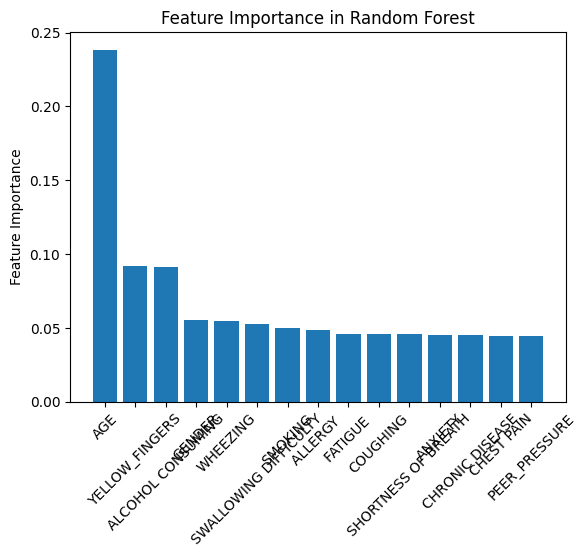

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

forests  = []
number_of_trees = range(50, 201)
for i in number_of_trees:
    random_forest = RandomForestClassifier(n_estimators = i, random_state = 888, max_features = "sqrt", criterion = "log_loss")
    forests.append(random_forest)

kf = KFold(n_splits = 10, shuffle = True, random_state = 888)
mean_cv_errors = []

for rf in forests:
    cv_scores = cross_val_score(rf, X_train, y_train, cv = kf, scoring = 'f1')
    mean_cv_errors.append(np.mean(cv_scores))  

optimal_number_of_trees_index = np.argmax(mean_cv_errors)
optimal_number_of_trees = number_of_trees[optimal_number_of_trees_index]
print(f"Optimal Number of Trees For Maximizing F1: {optimal_number_of_trees}")

new_forest = RandomForestClassifier(n_estimators = optimal_number_of_trees, random_state = 888, max_features = "sqrt", criterion = "log_loss")
new_forest.fit(X_train, y_train)
y_pred = new_forest.predict(X_val)

print(f"Corresponding Accuracy Score: {accuracy_score(y_pred, y_val)}")
print(f"Corresponding Precision Score: {precision_score(y_pred, y_val)}")
print(f"Corresponding Recall Score: {recall_score(y_pred, y_val)}")
print(f"Corresponding F1 Score: {f1_score(y_pred, y_val)}")

feature_importances = new_forest.feature_importances_

# Do a reverse sorted vertical bar plot
indices = np.argsort(feature_importances)[::-1]           # [::-1] reverses the order
plt.bar(np.array(feature_names)[indices], feature_importances[indices])
plt.ylabel('Feature Importance')
plt.title('Feature Importance in Random Forest')
plt.xticks(rotation=45)                                   # otherwist xticks is overcrowded with text
plt.show()

In [27]:

from itertools import combinations

fn_list = feature_names.drop("AGE")
pairwise_list = list(combinations(fn_list, 2))
for each_pair in pairwise_list:
    df_age[f"{each_pair[0]}*{each_pair[1]}"] = df_age[each_pair[0]] * df_age[each_pair[1]]

feature_names2 = df_age.columns.drop(["LUNG_CANCER"])
X = df_age[feature_names2].values
y = df_age["LUNG_CANCER"].values
X_train2, X_val2, y_train2, y_val2 = train_test_split(X, y, test_size = 0.2, random_state = 888)

forests  = []
number_of_trees = range(50, 201)
for i in number_of_trees:
    random_forest = RandomForestClassifier(n_estimators = i, random_state = 888, max_features = "sqrt", criterion = "log_loss")
    forests.append(random_forest)

kf = KFold(n_splits = 10, shuffle = True, random_state = 888)
mean_cv_errors = []

for rf in forests:
    cv_scores = cross_val_score(rf, X_train2, y_train2, cv = kf, scoring = 'precision')
    mean_cv_errors.append(np.mean(cv_scores))  

optimal_number_of_trees_index = np.argmax(mean_cv_errors)
optimal_number_of_trees = number_of_trees[optimal_number_of_trees_index]
print(f"Optimal Number of Trees: {optimal_number_of_trees}")

new_forest = RandomForestClassifier(n_estimators = optimal_number_of_trees, random_state = 888, max_features = "sqrt", criterion = "log_loss")
new_forest.fit(X_train2, y_train2)
y_pred = new_forest.predict(X_val2)

print(f"Corresponding Accuracy Score: {accuracy_score(y_pred, y_val2)}")
print(f"Corresponding Precision Score: {precision_score(y_pred, y_val2)}")
print(f"Corresponding Recall Score: {recall_score(y_pred, y_val2)}")
print(f"Corresponding F1 Score: {f1_score(y_pred, y_val2)}")

/var/folders/9r/srl_m58x5bb41c_98jfg0s_r0000gn/T/ipykernel_1182/4050591977.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age[f"{each_pair[0]}*{each_pair[1]}"] = df_age[each_pair[0]] * df_age[each_pair[1]]
/var/folders/9r/srl_m58x5bb41c_98jfg0s_r0000gn/T/ipykernel_1182/4050591977.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age[f"{each_pair[0]}*{each_pair[1]}"] = df_age[each_pair[0]] * df_age[each_pair[1]]
/var/folders/9r/srl_m58x5bb41c_98jfg0s_r0000gn/T/ipykernel_1182/4050591977.py:6: Set

Optimal Number of Trees: 62
Corresponding Accuracy Score: 0.8555555555555555
Corresponding Precision Score: 0.946927374301676
Corresponding Recall Score: 0.8805194805194805
Corresponding F1 Score: 0.9125168236877523


In [28]:
forests  = []
number_of_trees = range(50, 201)
for i in number_of_trees:
    random_forest = RandomForestClassifier(n_estimators = i, random_state = 888, max_features = "sqrt", criterion = "log_loss")
    forests.append(random_forest)

kf = KFold(n_splits = 10, shuffle = True, random_state = 888)
mean_cv_errors = []

for rf in forests:
    cv_scores = cross_val_score(rf, X_train2, y_train2, cv = kf, scoring = 'precision')
    mean_cv_errors.append(np.mean(cv_scores))  

optimal_number_of_trees_index = np.argmax(mean_cv_errors)
optimal_number_of_trees = number_of_trees[optimal_number_of_trees_index]
print(f"Optimal Number of Trees: {optimal_number_of_trees}")

new_forest = RandomForestClassifier(n_estimators = optimal_number_of_trees, random_state = 888, max_features = "sqrt", criterion = "log_loss")
new_forest.fit(X_train2, y_train2)
y_pred = new_forest.predict(X_val2)

print(f"Corresponding Accuracy Score: {accuracy_score(y_pred, y_val2)}")
print(f"Corresponding Precision Score: {precision_score(y_pred, y_val2)}")
print(f"Corresponding Recall Score: {recall_score(y_pred, y_val2)}")
print(f"Corresponding F1 Score: {f1_score(y_pred, y_val2)}")

Optimal Number of Trees: 62
Corresponding Accuracy Score: 0.8555555555555555
Corresponding Precision Score: 0.946927374301676
Corresponding Recall Score: 0.8805194805194805
Corresponding F1 Score: 0.9125168236877523
